In [4]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import lightning
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers.tensorboard import TensorBoardLogger
import utils
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_squared_error
import os
from models import TransformerModel


In [5]:
df_train, df_test, df_valid, mu, std = utils.load_cleaned_data()

BATCH_SIZE = 32


/home/unex/miniconda3/envs/tf/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type        | Params
--------------------------------------------
0 | transformer | Transformer | 1.5 K 
1 | criterion   | MSELoss     | 0     
--------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


TNN_ne1_nd1_sl12_nh1_df64


Mean Squared Error: 18.124477934261808
Root Mean Squared Error: 4.257285277528605


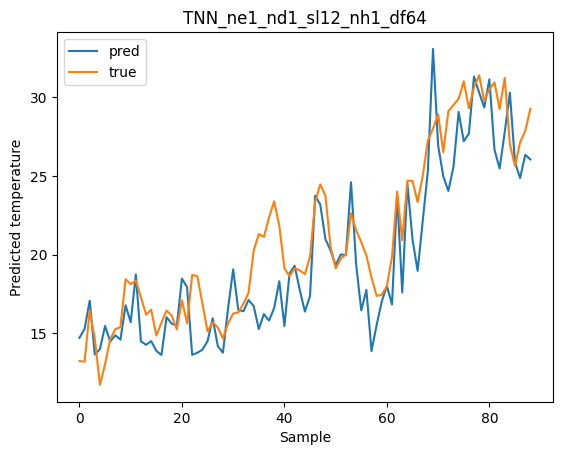

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type        | Params
--------------------------------------------
0 | transformer | Transformer | 1.5 K 
1 | criterion   | MSELoss     | 0     
--------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


TNN_ne1_nd1_sl12_nh2_df64


Exception ignored in: <function _releaseLock at 0x7f8e33b0cb80>
Traceback (most recent call last):
  File "/home/unex/miniconda3/envs/tf/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


In [6]:
num_encoder_layers = [1, 2, 3]
num_decoder_layers = [1, 2, 3]
src_lengths = [12, 24, 36, 100]
tgt_lengths = [12, 24, 36]
nheads = [1, 2, 4]
dim_feedforwards = [64]

folder = "transformer-report"

# Create folder if it does not exist
if not os.path.exists(folder):
    os.makedirs(folder)

stats_path = f"{folder}/stats.csv"

with open(stats_path, 'w') as stats_file:
    stats_file.write("NumEncoderLayers;NumDecoderLayers;SrcLen;TgtLen;NHeads;DimFeedforward;MSE;RMSE\n")

for num_encoders, num_decoders, src_len, tgt_len, nhead, dim_feedforward in product(num_encoder_layers, num_decoder_layers, src_lengths, tgt_lengths, nheads, dim_feedforwards):
    dataloader_train = torch.utils.data.DataLoader(utils.ClimateDataset(df_train, src_len, tgt_len, TransformerModel.START_TOKEN), batch_size=BATCH_SIZE, shuffle=False, num_workers=15)
    dataloader_valid = torch.utils.data.DataLoader(utils.ClimateDataset(df_valid, src_len, tgt_len, TransformerModel.START_TOKEN), batch_size=BATCH_SIZE, shuffle=False, num_workers=15)
    k = len(dataloader_train) // BATCH_SIZE

    model_name = f"TNN_ne{num_encoders}_nd{num_decoders}_sl{src_len}_tl{tgt_len}_nh{nhead}_df{dim_feedforward}"
    print(model_name)
    model = TransformerModel(input_size=4, learning_rate=0.001, num_encoder_layers=num_encoders, num_decoder_layers=num_decoders, nhead=nhead, dim_feedforward=dim_feedforward, seq_len=src_len)

    trainer = lightning.Trainer(
        accelerator="gpu",
        max_epochs=150,
        log_every_n_steps=k,
        callbacks=[
            EarlyStopping(monitor="val_loss", mode="min", patience=10, min_delta=0.01),
        ],
        logger=TensorBoardLogger("transformer-logs", name="", version=model_name)
    )

    trainer.fit(model, dataloader_train, dataloader_valid)

    dataloader_test = torch.utils.data.DataLoader(utils.ClimateDataset(df_test, src_len, tgt_len, TransformerModel.START_TOKEN), batch_size=1, shuffle=False, num_workers=15)
    preds, true = model.predict(dataloader_test)
    preds = preds * std.to_numpy() + mu.to_numpy()
    true = true * std.to_numpy() + mu.to_numpy()

    # and deliver us from evil
    mses = 0
    msei = 0
    for batch in range(preds.shape[0]):
        for tgt_item in range(preds.shape[2]):
            mse = mean_squared_error(true[batch, 0, tgt_item], preds[batch, 0, tgt_item])
            mses += mse
            msei += 1

    mse = mses / msei
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", np.sqrt(mse))
    plt.plot(preds[:,0,1,0], label="pred")
    plt.plot(true[:,0,1,0], label="true")
    plt.xlabel('Sample')
    plt.ylabel('Predicted temperature')
    plt.legend()
    plt.title(model_name)
    plt.savefig(f"{folder}/{model_name}.png")
    plt.show()

    with open(stats_path, 'a') as stats_file:
        stats_file.write(f"{num_encoders};{num_decoders};{src_len};{tgt_len};{nhead};{dim_feedforward};{mse};{np.sqrt(mse)}\n")
